**Autor:** [Lucas Lima](https://github.com/lucasouzamil)

# **Análise do Conjunto de Dados de Avaliação de Detecção de Intrusões (CIC-IDS2017)**

Este documento tem como propósito apresentar um resumo da [análise conduzida por Noushin Pervez](https://github.com/noushinpervez/Intrusion-Detection-CICIDS2017), na qual a autora explora e compara diferentes modelos de Machine Learning aplicados à detecção de intrusões, utilizando o [Conjunto de Dados CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html), desenvolvido pelo Canadian Institute for Cybersecurity.

A proposta deste resumo é implementar, de forma objetiva e simplificada, os dois modelos considerados mais eficazes pela autora em sua análise, tanto para classificação binária quanto para classificação multiclasses, a fim de reproduzir os resultados em um código mais enxuto e direto. Para informações adicionais ou aprofundamento teórico, recomenda-se a consulta ao estudo original.

Este material serve como base para o desenvolvimento de um sistema automatizado capaz de identificar e classificar ameaças cibernéticas em servidores web, com base em dados reais de tráfego de rede.

Trata-se de uma iniciativa com fins exclusivamente educacionais.

## 1. Coleta dos dados

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [ ]:
data1 = pd.read_csv('./data/CIC2017/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('./data/CIC2017/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('./data/CIC2017/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('./data/CIC2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('./data/CIC2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('./data/CIC2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('./data/CIC2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('./data/CIC2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [3]:
# Junção dos diferentes Datasets
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]
data = pd.concat(data_list)

In [4]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [5]:
# Removendo datasets para poupar memória
#for d in data_list: del d

In [6]:
# Renomeando as colunas para tirar espaços em branco
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [7]:
# Removendo coluna duplicada (Fwd Header Length e Fwd Header Length.1)
data.drop(columns=["Fwd Header Length.1"], inplace=True)

In [8]:
# Definir mapeamento de colunas (processamento -> real)
col_mapping = {
    'Destination Port': 'Dst Port',
    'Total Fwd Packets': 'Total Fwd Packet',
    'Total Backward Packets': 'Total Bwd packets',
    'Total Length of Fwd Packets': 'Total Length of Fwd Packet',
    'Total Length of Bwd Packets': 'Total Length of Bwd Packet',
    'Min Packet Length': 'Packet Length Min',
    'Max Packet Length': 'Packet Length Max',
    'Avg Fwd Segment Size': 'Fwd Segment Size Avg',
    'Avg Bwd Segment Size': 'Bwd Segment Size Avg',
    'Fwd Avg Bytes/Bulk': 'Fwd Bytes/Bulk Avg',
    'Fwd Avg Packets/Bulk': 'Fwd Packet/Bulk Avg',
    'Fwd Avg Bulk Rate': 'Fwd Bulk Rate Avg',
    'Bwd Avg Bytes/Bulk': 'Bwd Bytes/Bulk Avg',
    'Bwd Avg Packets/Bulk': 'Bwd Packet/Bulk Avg',
    'Bwd Avg Bulk Rate': 'Bwd Bulk Rate Avg',
    'Init_Win_bytes_forward': 'FWD Init Win Bytes',
    'Init_Win_bytes_backward': 'Bwd Init Win Bytes',
    'act_data_pkt_fwd': 'Fwd Act Data Pkts',
    'min_seg_size_forward': 'Fwd Seg Size Min',
    'CWE Flag Count': 'CWR Flag Count'
}

# ▶ 3. Renomear colunas
data = data.rename(columns=col_mapping)

In [9]:
features_reais = "Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label"
features_reais=features_reais.split(",")
features_modelo = list(data.columns)

for feature in features_reais:
    if feature not in features_modelo: print(feature)

print("XXXX")

for feature in features_modelo:
    if feature not in features_reais: print(feature)

Flow ID
Src IP
Src Port
Dst IP
Protocol
Timestamp
XXXX


In [10]:
data.describe().transpose()

/home/borg/Área de Trabalho/techhack/Intrusion-Detection-CICIDS2017/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/borg/Área de Trabalho/techhack/Intrusion-Detection-CICIDS2017/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Dst Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packet,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Bwd packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packet,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2830743.0,5.829582e+04,5.770923e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2830743.0,8.316037e+06,2.363008e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2830743.0,5.038439e+05,4.602984e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2830743.0,8.695752e+06,2.436689e+07,0.0,0.0,0.0,0.0,120000000.0


## 2. Pré-processamento de Dados

In [11]:
# Removendo linhas duplicadas (linhas iguais, todas features iguais)
data.drop_duplicates(inplace = True)

In [12]:
# Substituindo valores infinitos por NaN
data.replace([np.inf, -np.inf], np.nan, inplace = True)

In [13]:
# Corrigir colunas duplicadas (indices iguais)
data = data.loc[:, ~data.columns.duplicated()]

# Corrigir índice duplicado (transforma o índice em uma contagem sequencial (0, 1, 2, ...))
data = data.reset_index(drop=True)

In [14]:
# Identificando valores faltantes NaN
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [15]:
# Substituindo valores faltantes NaN pela mediana ()
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(med_flow_bytes)
data['Flow Packets/s'] = data['Flow Packets/s'].fillna(med_flow_packets)

In [16]:
# Dropando colunas que não alteram o valor
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Colunas Dropadas:')
dropped_cols

Colunas Dropadas:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
       'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg'],
      dtype='object')

In [17]:
# Criando um dicionario que mapeia cada label para seu tipo de ataque
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Criando uma nova coluna no DataBase usando o dicionario attack_map
data['Attack Type'] = data['Label'].map(attack_map)

In [18]:
#Dropando coluna antiga
data.drop('Label', axis = 1, inplace = True)

In [19]:
feature_order = [col for col in list(data.columns) if col != "Attack Type"]
data_prepro = data
data.columns

Index(['Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count

In [20]:
len(data.columns)

70

In [21]:
data.head(20)

,Dst Port,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
0,49188,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49486,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,88,879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,88,1160,9,6,3134,3048,1552,0,348.222222,682.482560,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,88,524,7,4,2812,2820,1397,0,401.714286,679.914876,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,1034,6,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,88,1119,9,6,3160,3060,1565,0,351.111111,688.214982,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [22]:
# Salva uma demo com apenas 20 amostras
data.sample(n=200, random_state=42).to_csv("data/demo_prepro.csv", index=False)

In [23]:
#salvando dados formatados
data_prepro.to_csv("data/data_prepro.csv", index=False)
import json
json.dump(list(feature_order), open("modelos/feature_order.json", "w"))



### Inicio da Pipeline

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/data_prepro.csv")

In [3]:
data.head(10)

,Dst Port,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
0,49188,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49486,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,88,879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,88,1160,9,6,3134,3048,1552,0,348.222222,682.482560,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,88,524,7,4,2812,2820,1397,0,401.714286,679.914876,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,1034,6,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,88,1119,9,6,3160,3060,1565,0,351.111111,688.214982,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
# Padronizando o dataset
from sklearn.preprocessing import StandardScaler

features = data.drop('Attack Type', axis = 1)
attacks = data['Attack Type']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
  ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.14%


In [6]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Attack Type'] = attacks.values

In [7]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,Attack Type
0,-2.357610,-0.054983,0.577384,0.734506,3.730427,0.234159,-0.215793,-0.277628,1.087729,0.032701,...,0.869394,-0.146296,-0.329932,1.490254,-0.195626,-0.184648,-0.004574,-0.001592,-0.029062,BENIGN
1,-2.883860,-0.069942,0.911339,1.763264,8.846304,0.619105,1.097237,1.912731,-2.755940,-0.950218,...,0.676611,0.279366,-2.342387,2.244380,-0.700029,-0.233638,0.007405,-0.002481,-0.049547,BENIGN
2,-2.416933,-0.056686,0.615353,0.850929,4.304282,0.275193,-0.071753,-0.033827,0.664627,-0.076140,...,0.845967,-0.100562,-0.541068,1.574828,-0.248754,-0.189357,-0.003384,-0.001704,-0.031074,BENIGN
3,-2.884710,-0.069983,0.912201,1.765380,8.851728,0.617367,1.095385,1.913159,-2.751966,-0.949845,...,0.674604,0.277804,-2.329917,2.245163,-0.697112,-0.232903,0.007263,-0.002495,-0.049284,BENIGN
4,-1.505248,0.080885,-0.504384,0.290438,-0.539280,0.746382,0.739116,-1.145780,-0.562622,-0.043700,...,-0.703462,-0.598198,0.118951,0.795409,-0.200681,0.076863,-0.014480,0.004399,0.053137,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,-2.270965,-0.048463,0.479996,0.461167,2.163945,-0.144811,-0.775629,-0.909008,2.711450,0.413677,...,0.736106,-0.040314,0.788980,0.784337,0.254411,0.000468,-0.016897,-0.000921,-0.008129,BENIGN
2522358,-2.267921,-0.048378,0.478567,0.457931,2.144129,-0.146827,-0.778422,-0.912163,2.718095,0.416247,...,0.732148,-0.038382,0.790335,0.785675,0.256042,0.002105,-0.017046,-0.000889,-0.007579,BENIGN
2522359,-2.267235,-0.048360,0.478245,0.457180,2.139667,-0.147267,-0.779036,-0.912852,2.719524,0.416812,...,0.731248,-0.037950,0.790475,0.785978,0.256355,0.002453,-0.017077,-0.000882,-0.007458,BENIGN
2522360,-2.102461,-0.041901,0.361542,0.268758,1.795840,0.284602,-0.294249,-0.631516,0.967058,0.081959,...,0.246504,-0.368728,1.793026,-0.927839,0.316733,0.070898,-0.004614,0.002837,0.056074,BENIGN


## 3. Modelos de	Machine Learning

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### Classificação Multiclasse (Random Forest)

In [9]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [ ]:
#scikitlearn undersampling para eliminar dados kar

class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

NameError: name 'new_data' is not defined

In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
DoS            5000
Brute Force    5000
Bot            5000
Port Scan      5000
DDoS           5000
BENIGN         5000
Web Attack     5000
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf.fit(X_train, y_train)

cv_rf = cross_val_score(rf, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9836190476190476, 0.9801904761904762, 0.98, 0.9817142857142858, 0.9847619047619047

Mean cross-validation score: 0.98


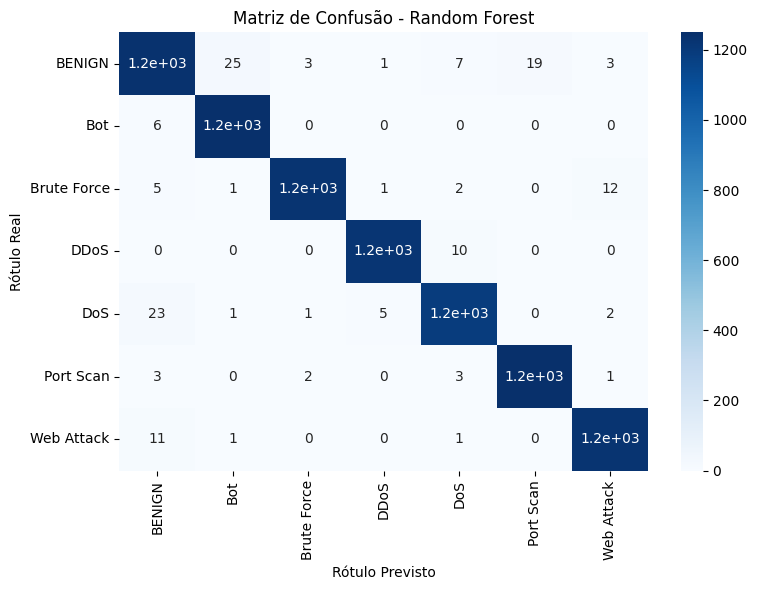

In [14]:
y_pred_rf = rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.tight_layout()
plt.show()

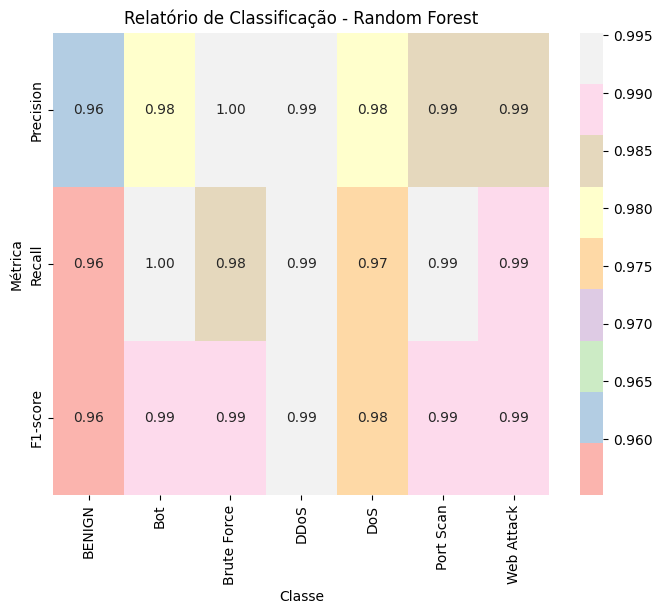

In [15]:
target_names = rf.classes_
metrics = classification_report(y_true=y_test, y_pred=y_pred_rf, target_names=target_names, output_dict=True)

precision = [metrics[target]['precision'] for target in target_names]
recall = [metrics[target]['recall'] for target in target_names]
f1 = [metrics[target]['f1-score'] for target in target_names]

data = [precision, recall, f1]
rows = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows)
plt.title('Relatório de Classificação - Random Forest')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.show()